## Marie 2020

Intensifying phase: Dorian 2019, Lester 2016, Sam 2021 (no MAXSS on this one)

Stationary phase: Hector 2018

Weakening phase: Marie 2020

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PATHS = {
    'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
}

### 1) SAR

In [3]:
### OPEN DATA
dsg = xr.open_dataset(PATHS['ds_glob_path'])

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
dsg.where(dsg.storm_name == 'MARIE', drop=True).B_hol

<xarray.DataArray 'B_hol' (time: 5)>
array([1.93012954, 2.53705701, 1.84006562, 1.9481579 , 1.98515194])
Coordinates:
  * time     (time) datetime64[ns] 2020-10-02T02:23:31 ... 2020-10-04T14:29:05

In [5]:
### MARIE
p1 = 'rs2--owi-ca-20201001t133839-20201001t133955-00003-3268A_sw_ep182020_cyclone.nc'
p2 = 'rs2--owi-ca-20201002t022254-20201002t022409-00003-3268A_sw_ep182020_cyclone.nc'
p3 = 's1a-ew-owi-ca-20201003t022600-20201003t022817-000003-04082E_sw_ep182020_cyclone.nc'
p4 = 'rs2--owi-ca-20201003t141913-20201003t142136-00003-3268A_sw_ep182020_cyclone.nc'
p5 = 's1b-ew-owi-ca-20201004t142803-20201004t143007-000003-02CF68_sw_ep182020_cyclone.nc'

Text(0.5, 1.0, 'MARIE, EP182020')

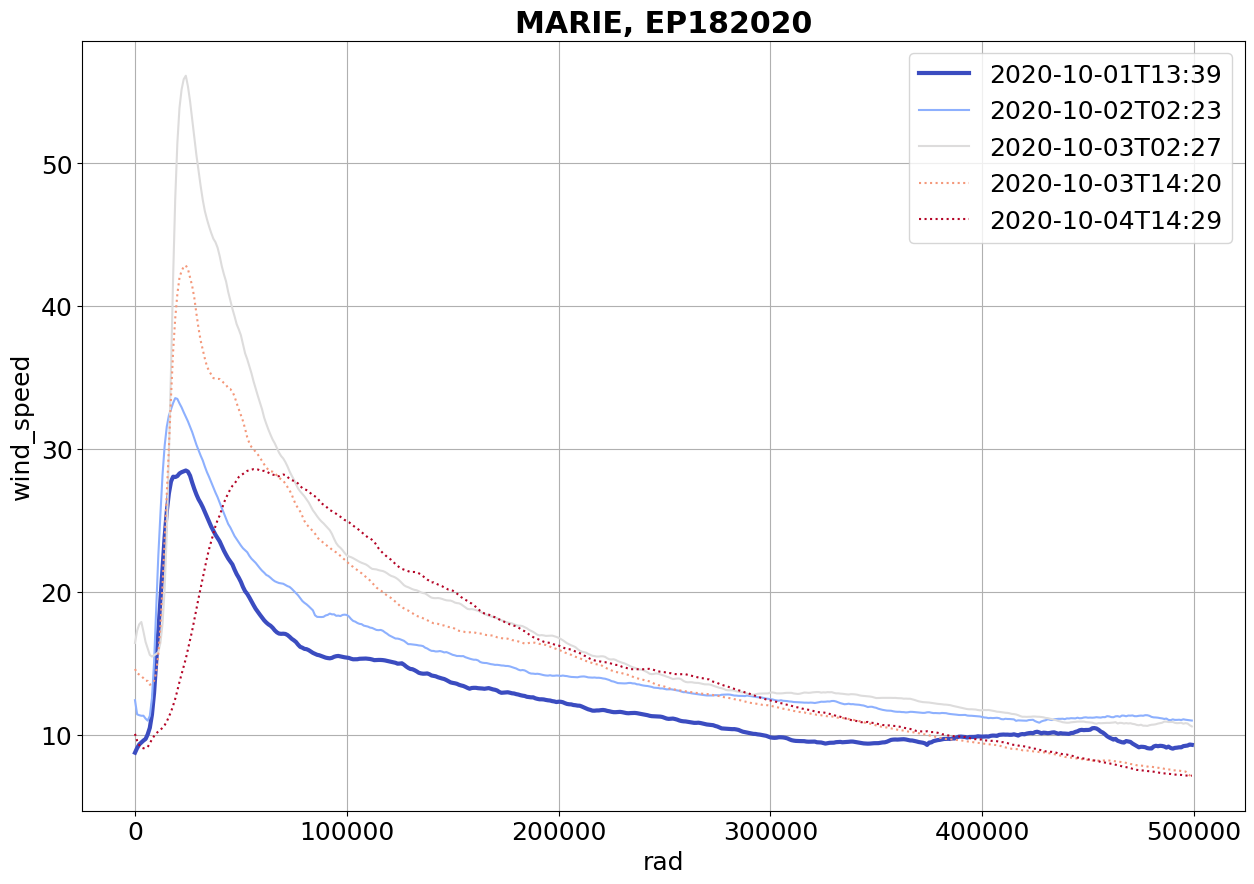

In [6]:
colors = mpl.cm.coolwarm(np.linspace(0, 1, 5))

ds1 = xr.open_dataset(PATHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PATHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PATHS['sar_dir'] + p3).isel(time=0)
ds4 = xr.open_dataset(PATHS['sar_dir'] + p4).isel(time=0)
ds5 = xr.open_dataset(PATHS['sar_dir'] + p5).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)
ws4 = ds4.wind_speed.mean(dim='theta', skipna=True)
ws5 = ds5.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c=colors[0], linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c=colors[1])
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c=colors[2])
ws4.plot(label='{}'.format(np.datetime_as_string(ds4.time, unit='m')), c=colors[3], linestyle='dotted')
ws5.plot(label='{}'.format(np.datetime_as_string(ds5.time, unit='m')), c=colors[4], linestyle='dotted')
plt.grid();plt.legend();plt.title('MARIE, EP182020', weight='bold')

# 36hrs between both images

In [7]:
### FUNCTIONS

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def get_scales(ds, H=10000, show=True, L=100000, delta_t=24):
    lat    = float(ds.lat.isel(rad=0).mean(dim='theta', skipna=True))
    fcor   = abs(coriolis(lat)) # maybe divide by 10 to get reasonable value of fcor * L

    # To define U_star
    ws     = ds.wind_speed.mean(dim='theta', skipna=True)
    Rmax   = float(ws.rad[int(ws.argmax())]) # m
    Vmax   = float(ws.max())                  # m/s
    U_star = fcor * Rmax # m/s

    if show:
        print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
        print('radial velocity     --> {:.2f} m/s'.format(U_star))
        print('tangential velocity --> {:.2f} m/s'.format(fcor * L))
        print('vertical velocity   --> {:.2f} m/s'.format(H * U_star / L))
        print('characteristic tangential velocity --> {:.1f} m/s'.format(fcor * L)) 
        print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))
    
    return Vmax, Rmax, fcor

def get_v(ds, fcor, L):
    ws = ds.wind_speed.mean(dim='theta', skipna=True)
    r = ws.rad / L
    v = ws     / (fcor * L)

    V = xr.DataArray(
        data=v,
        coords={'rad': r}
    )
    return V

def v_k10(v0, t, lbda):
    v          = np.zeros_like(v0.rad)
    # Inner-core
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)})
    vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)
    # Near-core
    nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t))
    v_prop_nr  = v0.interp({'rad': nr_term})
    vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
    # Outer-core
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)
    v_prop_ou  = v0.interp({'rad': ou_term})
    vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad)

    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

In [8]:
# Define wind speeds
print('1)')
L1                  = 134000
Vmax1, Rmax1, fcor1 = get_scales(ds1, L=L1, delta_t=12)
V1                  = get_v(ds1, fcor1, L1)

print('\n2)')
L2                  = 142000
Vmax2, Rmax2, fcor2 = get_scales(ds2, L=L2, delta_t=24)
V2                  = get_v(ds2, fcor2, L2)

print('\n3)')
L3                  = 107000
Vmax3, Rmax3, fcor3 = get_scales(ds3, L=L3, delta_t=12)
V3                  = get_v(ds3, fcor3, L3)

print('\n4)')
L4                  = 146000
Vmax4, Rmax4, fcor4 = get_scales(ds4, L=L4, delta_t=24)
V4                  = get_v(ds4, fcor4, L4)

print('\n5)')
L5                  = 193000
Vmax5, Rmax5, fcor5 = get_scales(ds5, show=False, L=L5)
V5                  = get_v(ds5, fcor5, L5)

1)
characteristic time --> 41.8 h
radial velocity     --> 0.89 m/s
tangential velocity --> 4.97 m/s
vertical velocity   --> 0.07 m/s
characteristic tangential velocity --> 5.0 m/s
nb of timesteps: 0.29

2)
characteristic time --> 53.6 h
radial velocity     --> 0.74 m/s
tangential velocity --> 5.50 m/s
vertical velocity   --> 0.05 m/s
characteristic tangential velocity --> 5.5 m/s
nb of timesteps: 0.45

3)
characteristic time --> 28.6 h
radial velocity     --> 1.04 m/s
tangential velocity --> 4.63 m/s
vertical velocity   --> 0.10 m/s
characteristic tangential velocity --> 4.6 m/s
nb of timesteps: 0.42

4)
characteristic time --> 36.8 h
radial velocity     --> 1.10 m/s
tangential velocity --> 6.70 m/s
vertical velocity   --> 0.08 m/s
characteristic tangential velocity --> 6.7 m/s
nb of timesteps: 0.65

5)


In [9]:
# lbda  = 0.4
# v_new = v_k10(V1, t=0.29, lbda=lbda)
# plt.plot(ws1.rad, ws1, label='SAR t', c='k', linewidth=3)
# plt.plot(V1.rad * L1, v_new * fcor1 * L1, label='KK11', c='tab:orange')
# plt.plot(ws2.rad, ws2, label='SAR t + dt', c='k', linestyle='--')
# plt.grid();plt.xlim(0, 500000)
# plt.legend()

In [10]:
# lbda  = -0.1
# v_new = v_k10(V2, t=0.45, lbda=lbda)
# plt.plot(ws2.rad, ws2, label='SAR t', c='k', linewidth=3)
# plt.plot(V2.rad * L2, v_new * fcor2 * L2, label='KK11', c='tab:orange')
# plt.plot(ws3.rad, ws3, label='SAR t + dt', c='k', linestyle='--')
# plt.grid();plt.xlim(0, 500000)
# plt.legend()

In [11]:
# lbda  = 1.6
# v_new = v_k10(V3, t=0.42, lbda=lbda)
# plt.plot(ws3.rad, ws3, label='SAR t', c='k', linewidth=3)
# plt.plot(V3.rad * L3, v_new * fcor3 * L3, label='KK11', c='tab:orange')
# plt.plot(ws4.rad, ws4, label='SAR t + dt', c='k', linestyle='--')
# plt.grid();plt.xlim(0, 500000)
# plt.legend()

In [12]:
# lbda  = 1.6
# v_new = v_k10(V4, t=0.65, lbda=lbda)
# plt.plot(ws4.rad, ws4, label='SAR t', c='k', linewidth=3)
# plt.plot(V4.rad * L4, v_new * fcor4 * L4, label='KK11', c='tab:orange')
# plt.plot(ws5.rad, ws5, label='SAR t + dt', c='k', linestyle='--')
# plt.grid();plt.xlim(0, 500000)
# plt.legend()

### 2) Scatterometer only

In [13]:
### OPEN DATA
all_sct = glob.glob(PATHS['sct_dir'] + '*.nc')
print('nb of scat files = ', len(all_sct))

nb of scat files =  57


In [14]:
def path2datetime(path):
    '''
    Given a path like: '/home/arthur/data/scatterometer/KNMI/metop_c/ascat/2019/025/ascat_20190125_144500_metopc_01131_srv_o_125_ovw.nc'
    returns the datetime object corresponding to acquisition start time: datetime.datetime(2019, 1, 25, 14, 45)
    '''
    dt_as_list = re.split(r'(\d+)', os.path.basename(path))[1:4] # ['20150403', '_', '071800']
    dt_conc    = ''.join(dt_as_list)                             # '20150403T071800'
    return datetime.strptime(dt_conc, "%Y%m%d_%H%M%S")

In [15]:
# Sort all files
all_sct = sorted(all_sct, key=path2datetime)
# Custom list
all_sct = all_sct[22:]

#### Initialization

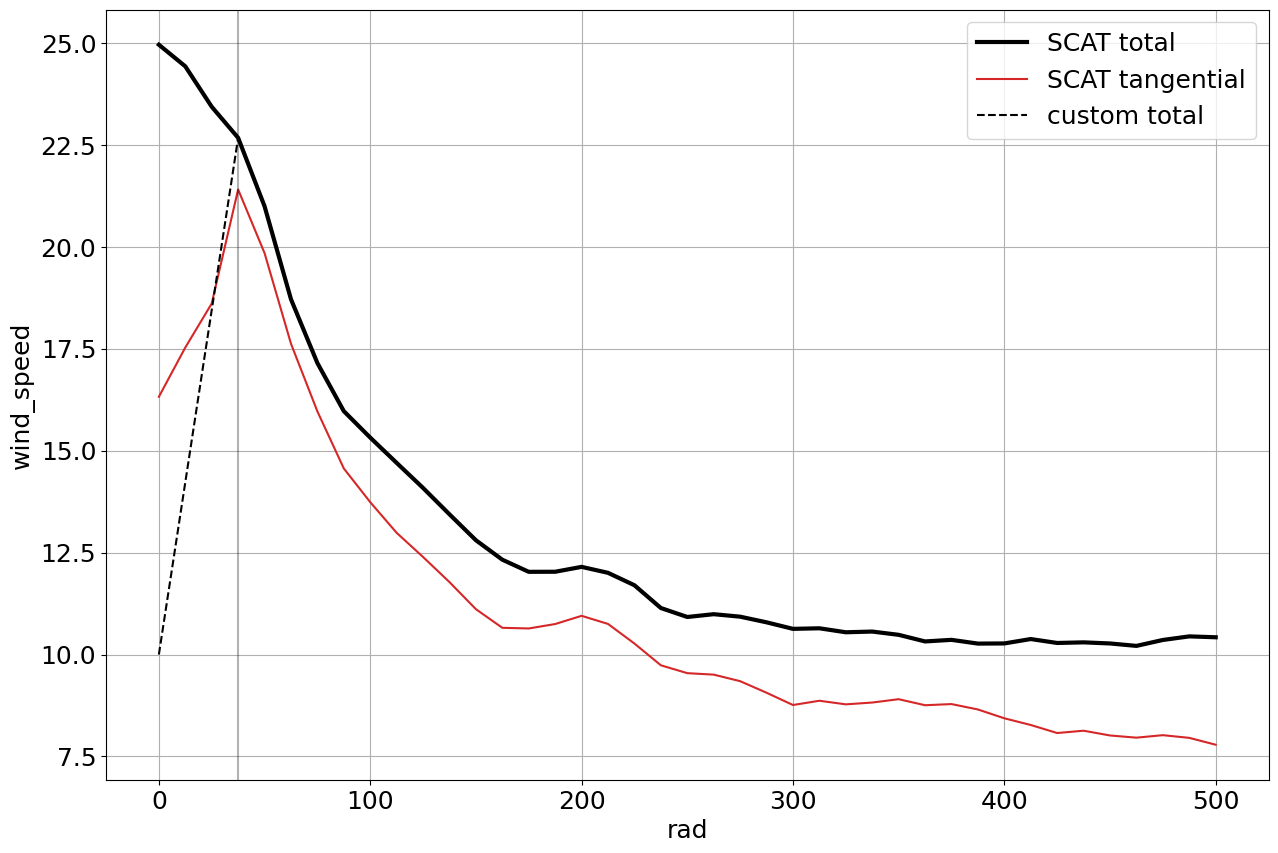

In [16]:
# Initialization
dss = xr.open_dataset(all_sct[0])
dss.wind_speed.mean(dim='theta', skipna=True).plot(c='k', linewidth=3, label='SCAT total')
dss.tangential_wind.mean(dim='theta', skipna=True).plot(c='tab:red', label='SCAT tangential')
plt.axvline(37.5, c='k', alpha=0.3)

# Custom initialization
def affine(vmax, vmin, rmax, r):
    return ((vmax - vmin) / (rmax - 0)) * r + vmin

V_ini        = dss.wind_speed.mean(dim='theta', skipna=True)
V_ini[0]     = 10
V_ini[1]     = affine(vmax=V_ini.sel(rad=37.5), vmin=10, rmax=37.5, r=1 * 12.5)
V_ini[2]     = affine(vmax=V_ini.sel(rad=37.5), vmin=10, rmax=37.5, r=2 * 12.5)
V_ini.plot(c='k', linestyle='--', label='custom total')
plt.legend();plt.grid()

# Convert to meters
V_ini['rad'] = V_ini.rad * 1000

#### 1st iteration

In [17]:
# Define characteristic scales
L      = 150000
fcor   = float(coriolis(dss.lat_IBT))
Rmax   = 37500
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('latitude            --> {:.1f}°'.format(dss.lat_IBT))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))


V0 = xr.DataArray(
    data=V_ini / (fcor * L),
    coords={'rad': V_ini.rad / L}
)

radial velocity U*  --> 1.38 m/s
characteristic time --> 30.3 h
latitude            --> 14.6°
nb of timesteps: 0.40


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-pac

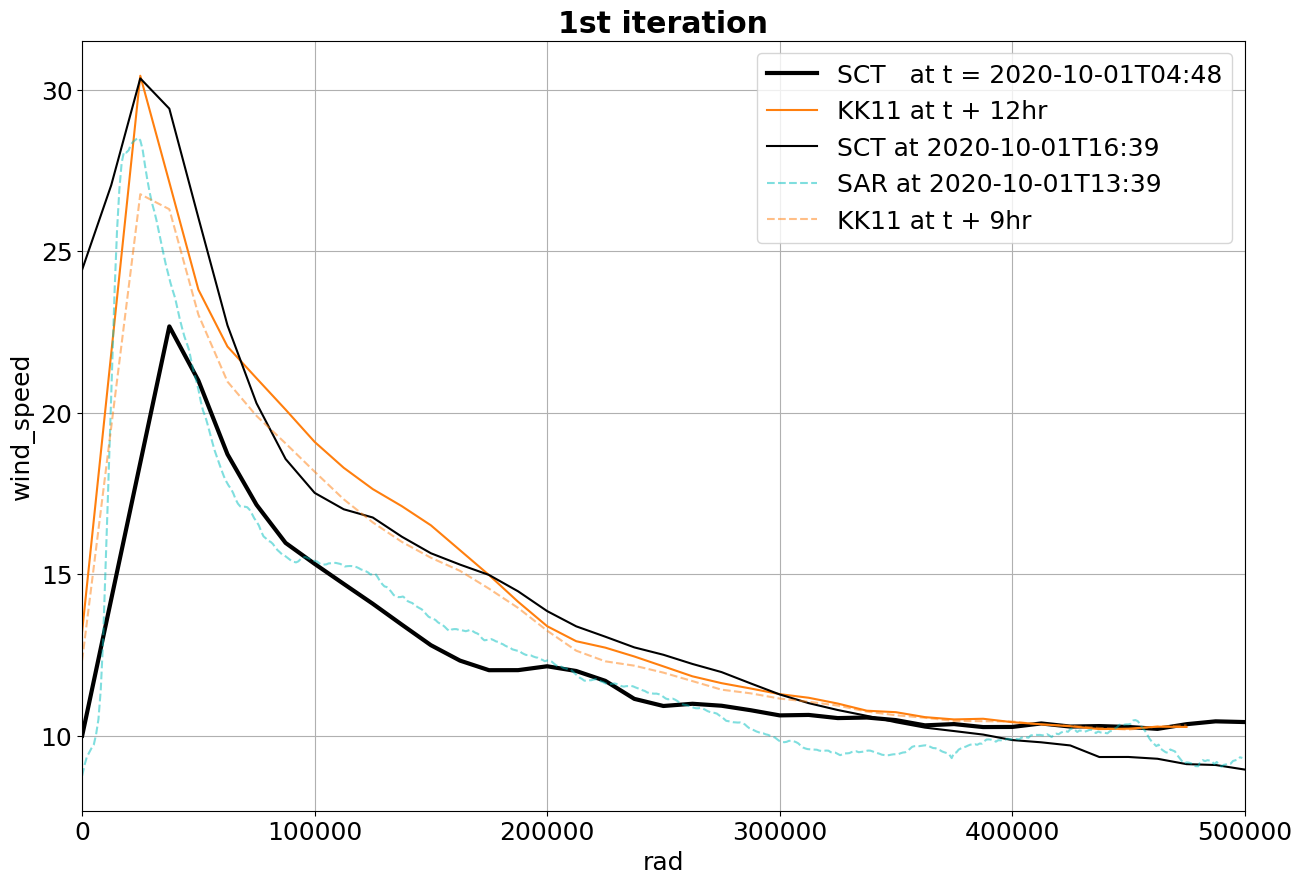

In [18]:
lbda  = 0.3
v_new = v_k10(V0, t=0.40, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V0.rad * L, V0 * fcor * L, label='SCT   at t = {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[0])), unit='m')), c='k', linewidth=3)
plt.plot(V0.rad * L, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# NEXT SCAT
dss_next        = xr.open_dataset(all_sct[5])
dss_next['rad'] = dss_next.rad * 1000
v_next_sct      = dss_next.wind_speed.mean(dim='theta', skipna=True)
v_next_sct.plot(label='SCT at {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[5])), unit='m')), c='k')

# INTERMEDIARY SAR AND MODEL
ws1.plot(label='SAR at {}'.format(np.datetime_as_string(ds1.time, unit='m')), c='c', linestyle='--', alpha=0.5)
plt.plot(V0.rad * L, v_k10(V0, t=0.30, lbda=lbda) * fcor * L, label='KK11 at t + 9hr', c='tab:orange', linestyle='--', alpha=0.5)

plt.title('1st iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

### SAVE v_new
V_NEW = xr.DataArray(
    data=v_new * fcor * L,
    coords={'rad': V0.rad * L}
)

#### 2nd iteration

In [19]:
# Define characteristic scales
# L      = 130000
fcor   = float(coriolis(dss_next.lat_IBT))
Rmax   = 30000
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))

V = xr.DataArray(
    data=V_NEW / (fcor * L),
    coords={'rad': V_NEW.rad / L}
)

radial velocity U*  --> 1.12 m/s
characteristic time --> 37.1 h
nb of timesteps: 0.32


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-pac

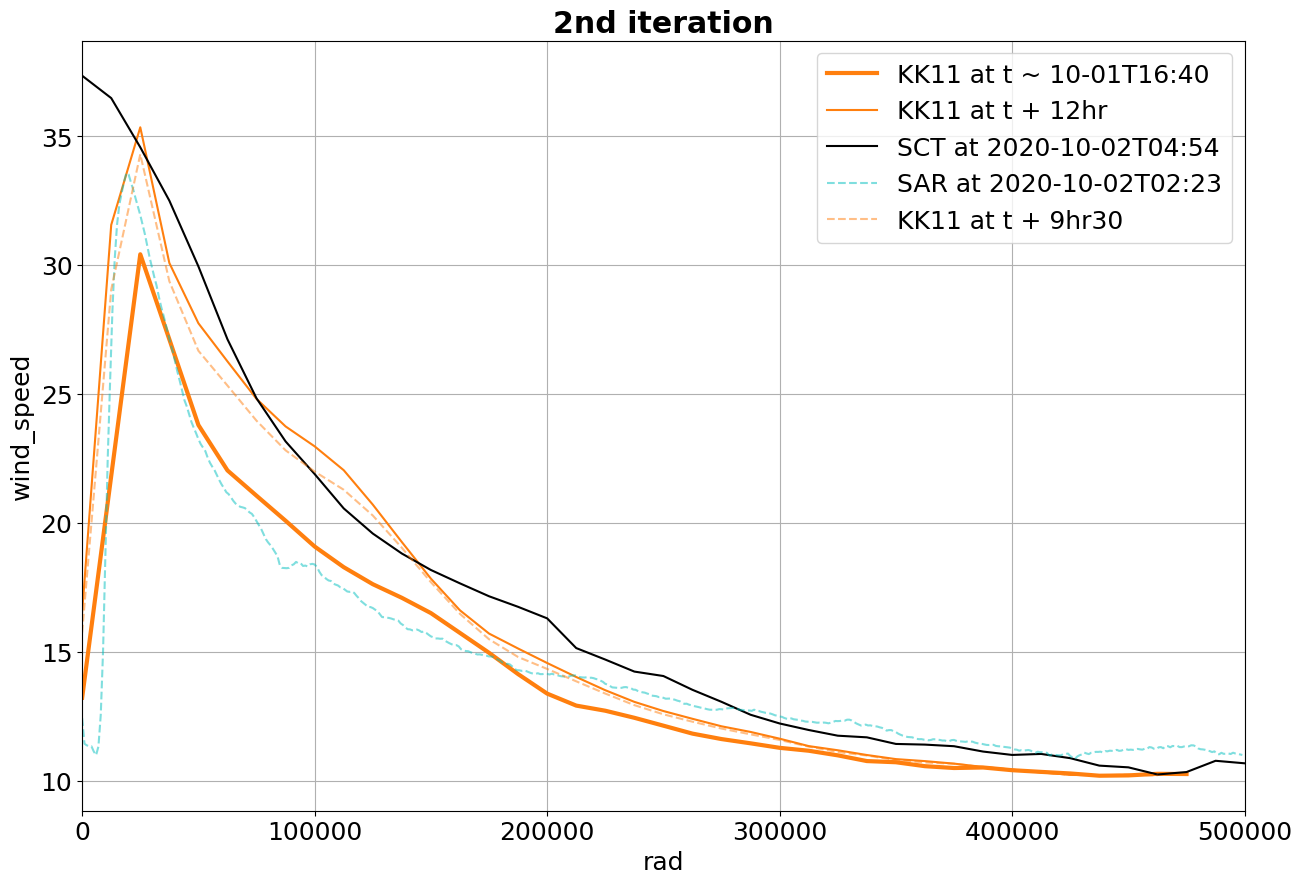

In [21]:
lbda  = 0.3
v_new = v_k10(V, t=0.32, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V_NEW.rad, V_NEW,            label='KK11 at t ~ 10-01T16:40', c='tab:orange', linewidth=3)
plt.plot(V.rad * L, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# NEXT SCAT
dss_next        = xr.open_dataset(all_sct[8])
dss_next['rad'] = dss_next.rad * 1000
v_next_sct      = dss_next.wind_speed.mean(dim='theta', skipna=True)
v_next_sct.plot(label='SCT at {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[8])), unit='m')), c='k')

# # INTERMEDIARY SAR AND MODEL
ws2.plot(label='SAR at {}'.format(np.datetime_as_string(ds2.time, unit='m')), c='c', linestyle='--', alpha=0.5)
plt.plot(V.rad * L, v_k10(V, t=0.25, lbda=lbda) * fcor * L, label='KK11 at t + 9hr30', c='tab:orange', linestyle='--', alpha=0.5)

plt.title('2nd iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

### SAVE v_new
V_NEW = xr.DataArray(
    data=v_new * fcor * L,
    coords={'rad': V.rad * L}
)

#### 3rd iteration

In [22]:
# Define characteristic scales
# L      = 120000
fcor   = float(coriolis(dss_next.lat_IBT))
Rmax   = 22000
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))

V = xr.DataArray(
    data=V_NEW / (fcor * L),
    coords={'rad': V_NEW.rad / L}
)

radial velocity U*  --> 0.87 m/s
characteristic time --> 47.6 h
nb of timesteps: 0.25


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


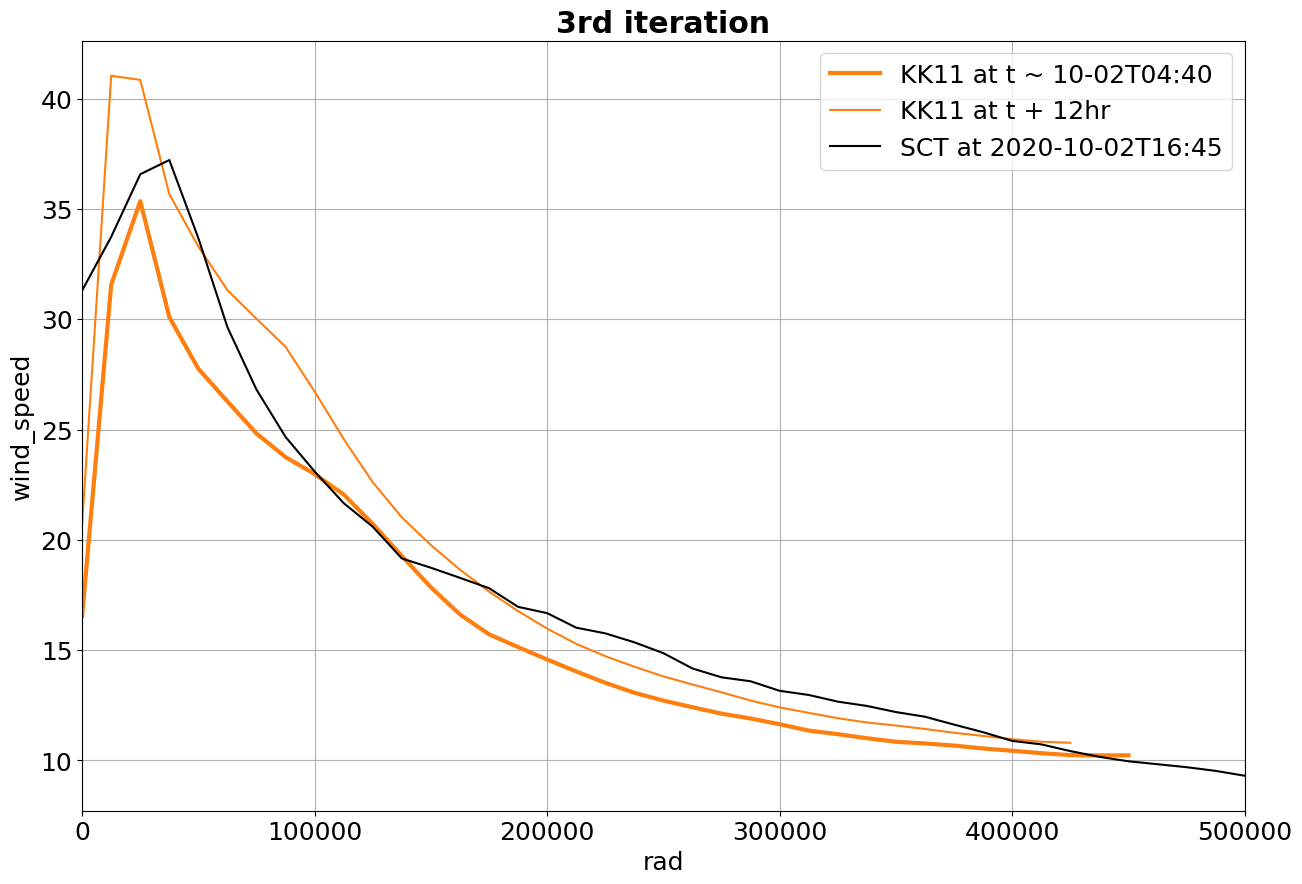

In [24]:
lbda  = 0.1
v_new = v_k10(V, t=0.25, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V_NEW.rad, V_NEW,            label='KK11 at t ~ 10-02T04:40', c='tab:orange', linewidth=3)
plt.plot(V.rad * L, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# NEXT SCAT
dss_next        = xr.open_dataset(all_sct[10])
dss_next['rad'] = dss_next.rad * 1000
v_next_sct      = dss_next.wind_speed.mean(dim='theta', skipna=True)
v_next_sct.plot(label='SCT at {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[10])), unit='m')), c='k')

plt.title('3rd iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

### SAVE v_new
V_NEW = xr.DataArray(
    data=v_new * fcor * L,
    coords={'rad': V.rad * L}
)

#### 4th iteration

In [25]:
# Define characteristic scales
# L      = 110000
fcor   = float(coriolis(dss_next.lat_IBT))
Rmax   = 11000
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))

V = xr.DataArray(
    data=V_NEW / (fcor * L),
    coords={'rad': V_NEW.rad / L}
)

radial velocity U*  --> 0.46 m/s
characteristic time --> 91.1 h
nb of timesteps: 0.13


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-pac

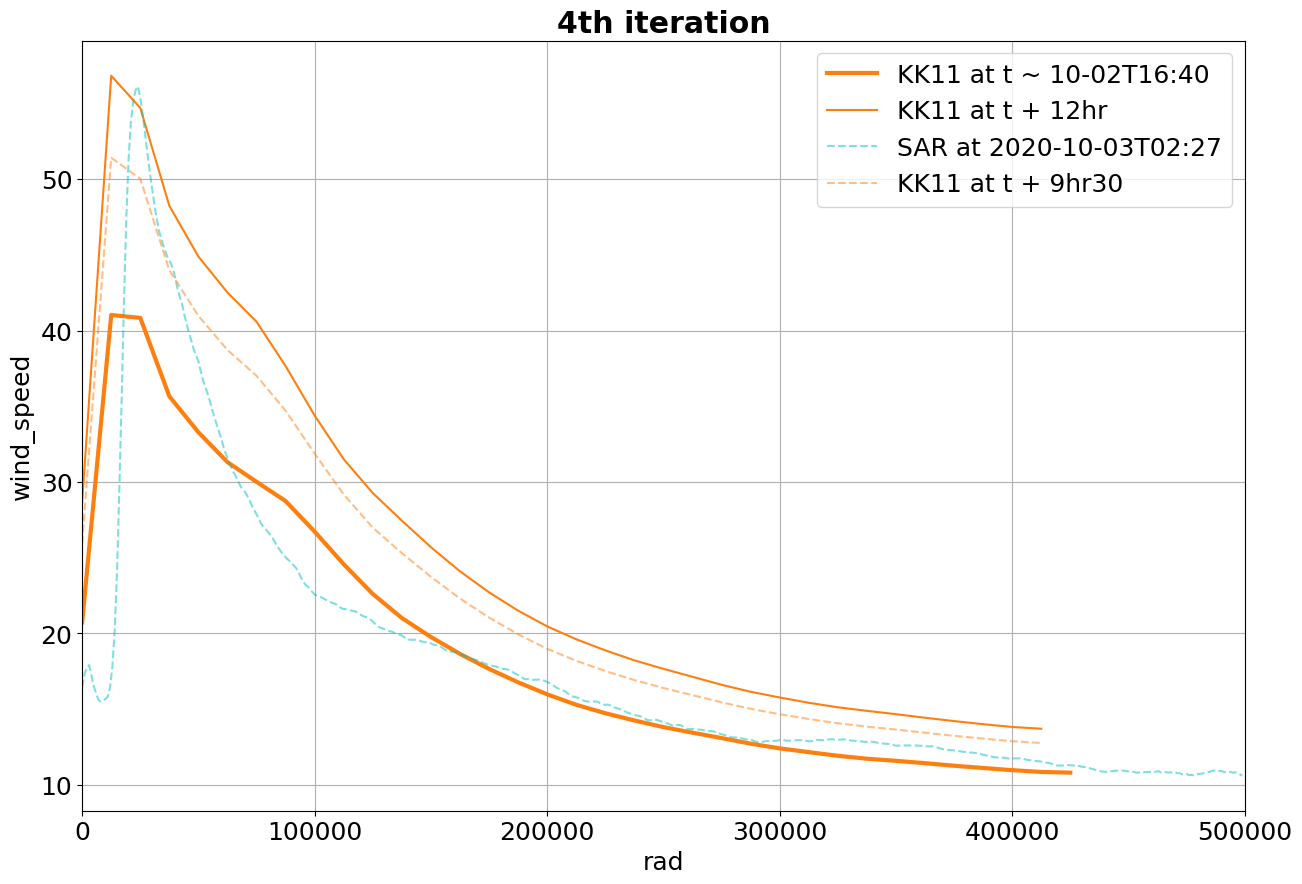

In [30]:
lbda  = -1.5
v_new = v_k10(V, t=0.13, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V_NEW.rad, V_NEW,            label='KK11 at t ~ 10-02T16:40', c='tab:orange', linewidth=3)
plt.plot(V.rad * L, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# # NEXT SCAT
### ==> NO VALID SCAT BEFORE 10-04t04:17

# # # INTERMEDIARY SAR AND MODEL
ws3.plot(label='SAR at {}'.format(np.datetime_as_string(ds3.time, unit='m')), c='c', linestyle='--', alpha=0.5)
plt.plot(V.rad * L, v_k10(V, t=0.09, lbda=lbda) * fcor * L, label='KK11 at t + 9hr30', c='tab:orange', linestyle='--', alpha=0.5)

plt.title('4th iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

# ### SAVE v_new
# V_NEW = xr.DataArray(
#     data=v_new * fcor * L,
#     coords={'rad': V.rad * L}
# )

#### 5th iteration

In [25]:
# Define characteristic scales
# L      = 140000
fcor   = float(coriolis(dss_next.lat_IBT + 1.2)) # Data is missing ==> 1° is 100km, saying the storm goes at 10km/h, it has done ~1.2° in 12 hrs
Rmax   = 11000
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('latitude            --> {:.1f}°'.format(dss_next.lat_IBT + 1.2))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))

V = xr.DataArray(
    data=V_NEW / (fcor * L),
    coords={'rad': V_NEW.rad / L}
)

radial velocity U*  --> 0.49 m/s
characteristic time --> 85.1 h
latitude            --> 17.8°
nb of timesteps: 0.14


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-pac

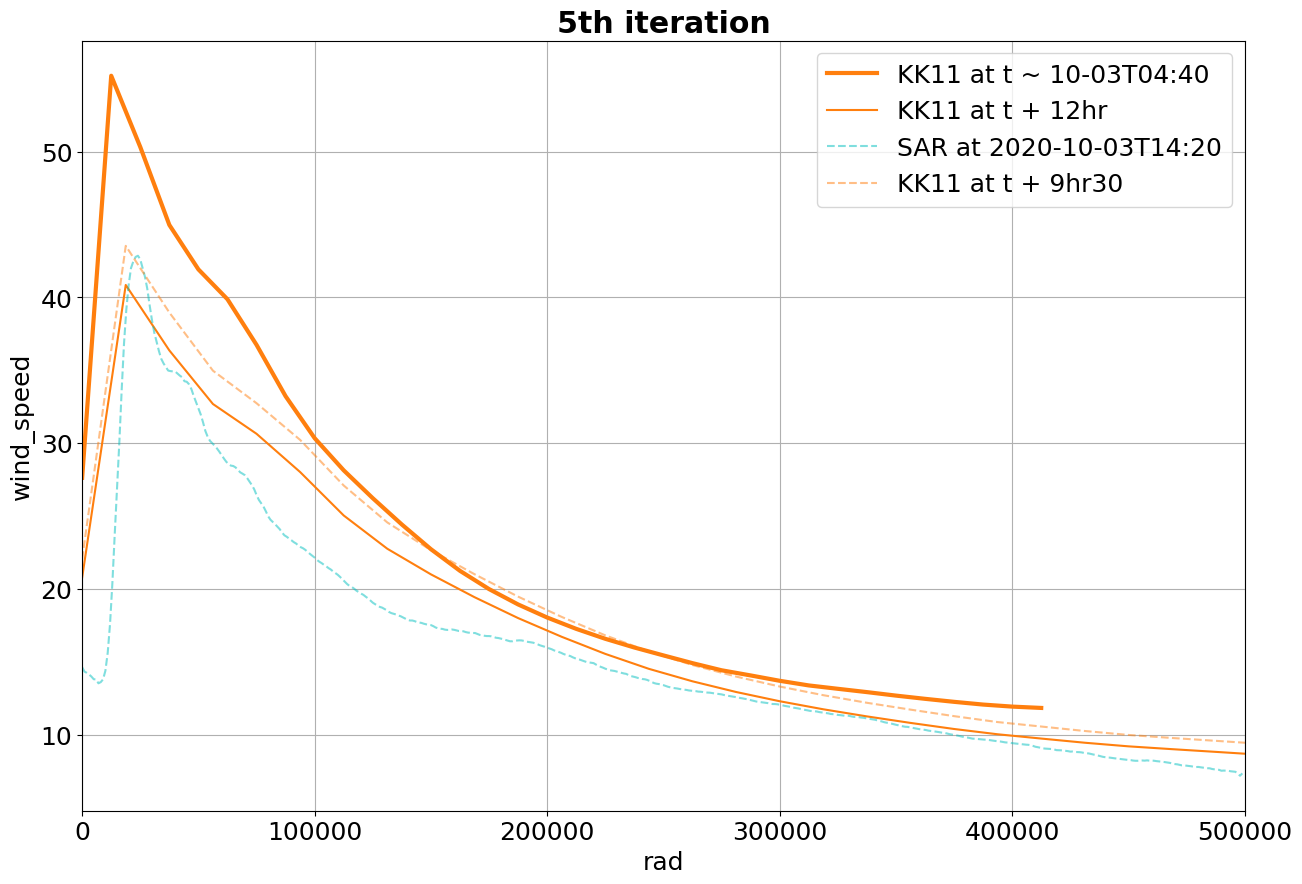

In [26]:
lbda  = 2.5
v_new = v_k10(V, t=0.19, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V_NEW.rad, V_NEW,            label='KK11 at t ~ 10-03T04:40', c='tab:orange', linewidth=3)
plt.plot(V.rad * L * 1.5, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# # NEXT SCAT
### ==> NO VALID SCAT BEFORE 10-04t04:17

# INTERMEDIARY SAR AND MODEL
ws4.plot(label='SAR at {}'.format(np.datetime_as_string(ds4.time, unit='m')), c='c', linestyle='--', alpha=0.5)
plt.plot(V.rad * L * 1.5, v_k10(V, t=0.15, lbda=lbda) * fcor * L, label='KK11 at t + 9hr30', c='tab:orange', linestyle='--', alpha=0.5)

plt.title('5th iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

### SAVE v_new
V_NEW = xr.DataArray(
    data=v_new * fcor * L,
    coords={'rad': V.rad * L}
)

#### 6th iteration

In [27]:
# Define characteristic scales
# L      = 200000
fcor   = float(coriolis(dss_next.lat_IBT + 2 * 1.2)) # Data is missing ==> 1° is 100km, saying the storm goes at 10km/h, it has done ~1.2° in 12 hrs
Rmax   = 15000
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))

V = xr.DataArray(
    data=V_NEW / (fcor * L),
    coords={'rad': V_NEW.rad / L}
)

radial velocity U*  --> 0.71 m/s
characteristic time --> 58.6 h
nb of timesteps: 0.20


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


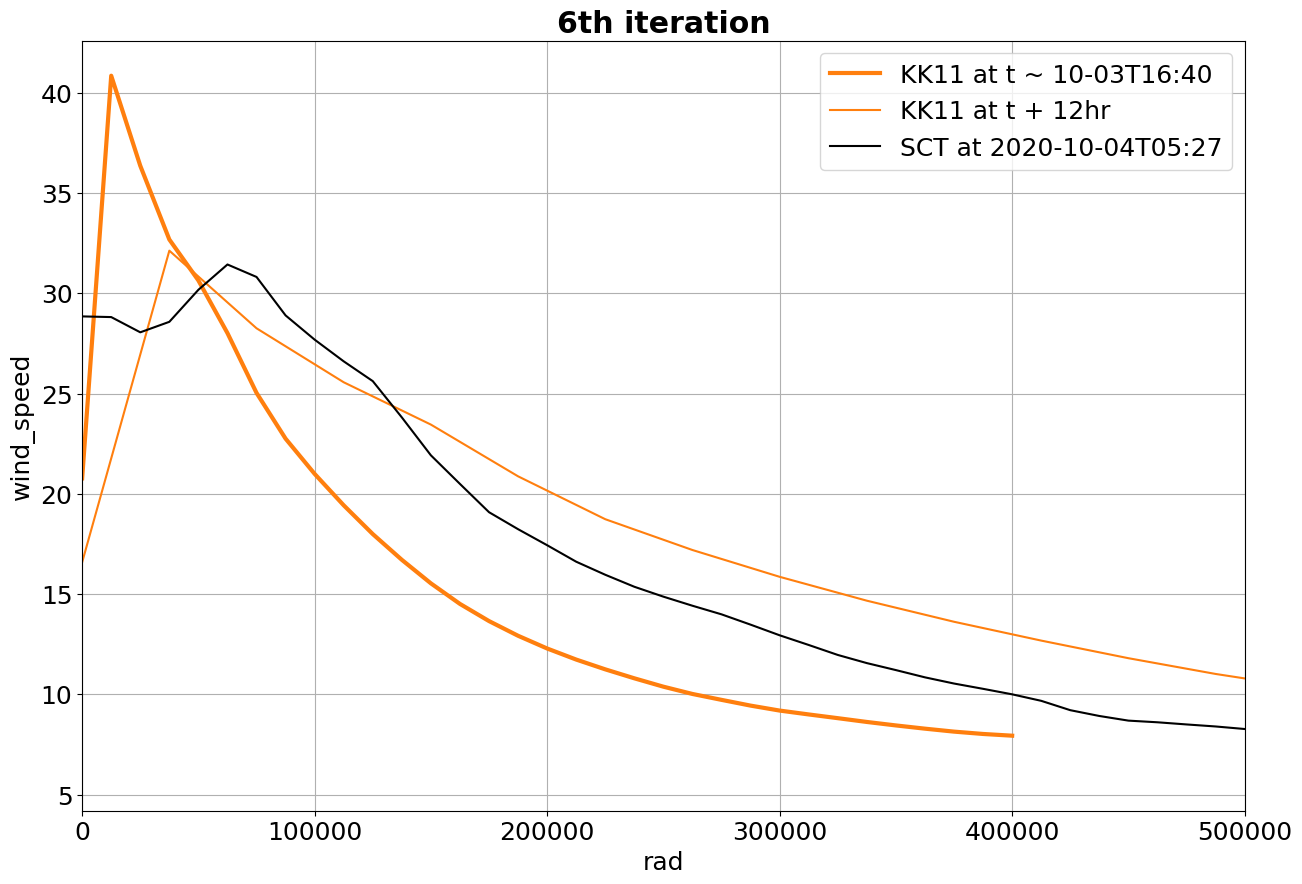

In [28]:
lbda  = 2.5
v_new = v_k10(V, t=0.15, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V_NEW.rad, V_NEW,            label='KK11 at t ~ 10-03T16:40', c='tab:orange', linewidth=3)
plt.plot(V.rad * L * 3, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# NEXT SCAT
dss_next        = xr.open_dataset(all_sct[16])
dss_next['rad'] = dss_next.rad * 1000
v_next_sct      = dss_next.wind_speed.mean(dim='theta', skipna=True)
v_next_sct.plot(label='SCT at {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[16])), unit='m')), c='k')

plt.title('6th iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

### SAVE v_new
V_NEW = xr.DataArray(
    data=v_new * fcor * L,
    coords={'rad': V.rad * L}
)

#### 7th iteration

In [29]:
# Define characteristic scales
# L      = 300000
fcor   = float(coriolis(dss_next.lat_IBT))
Rmax   = 70000
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('latitude            --> {:.1f}°'.format(dss_next.lat_IBT))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))

V = xr.DataArray(
    data=V_NEW / (fcor * L),
    coords={'rad': V_NEW.rad / L}
)

radial velocity U*  --> 3.43 m/s
characteristic time --> 12.1 h
latitude            --> 19.6°
nb of timesteps: 0.99


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-pac

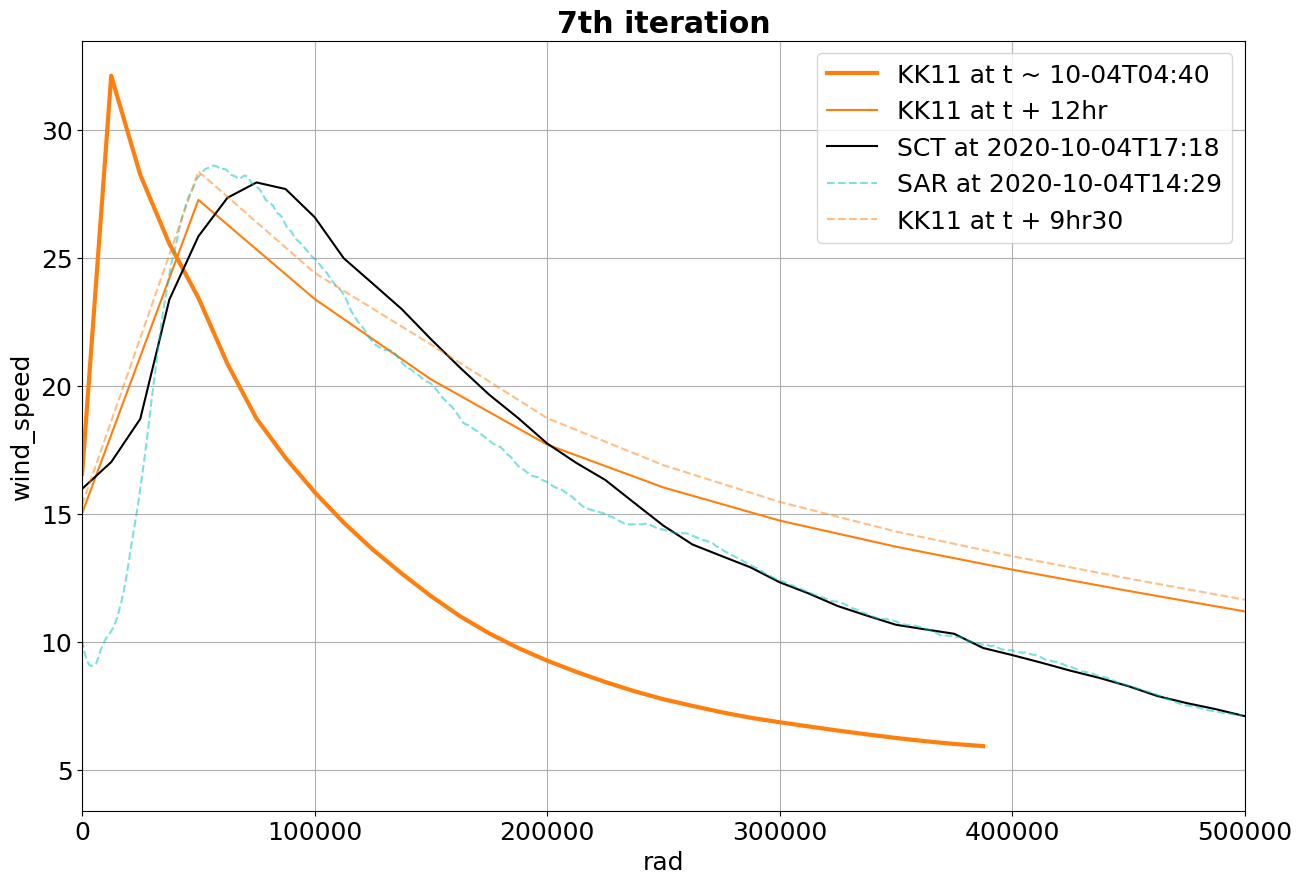

In [30]:
lbda  = 1.2
v_new = v_k10(V, t=0.49, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V_NEW.rad, V_NEW,            label='KK11 at t ~ 10-04T04:40', c='tab:orange', linewidth=3)
plt.plot(V.rad * L * 4, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# NEXT SCAT
dss_next        = xr.open_dataset(all_sct[20])
dss_next['rad'] = dss_next.rad * 1000
v_next_sct      = dss_next.wind_speed.mean(dim='theta', skipna=True)
v_next_sct.plot(label='SCT at {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[20])), unit='m')), c='k')

# INTERMEDIARY SAR AND MODEL
ws5.plot(label='SAR at {}'.format(np.datetime_as_string(ds5.time, unit='m')), c='c', linestyle='--', alpha=0.5)
plt.plot(V.rad * L * 4, v_k10(V, t=0.38, lbda=lbda) * fcor * L, label='KK11 at t + 9hr30', c='tab:orange', linestyle='--', alpha=0.5)

plt.title('7th iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

# ### SAVE v_new
# V_NEW = xr.DataArray(
#     data=v_new * fcor * L,
#     coords={'rad': V.rad * L}
# )